In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import os
import shutil

In [4]:
DATASET_PATH = os.path.join('../', 'kitti', 'dataset')
IMAGE_PATH = os.path.join(DATASET_PATH, 'sequences', '00', 'image_0') 

In [5]:
left_images = sorted(os.listdir(IMAGE_PATH))
gen = (cv2.imread(os.path.join(IMAGE_PATH, img)) for img in left_images)

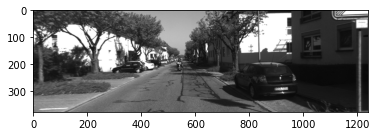

In [6]:
plt.imshow(next(gen))

In [7]:
calib = pd.read_csv(os.path.join(DATASET_PATH, 'sequences', '00', 'calib.txt'), delimiter=' ', header = None, index_col = 0)
calib

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856,0.0,607.1928,0.00000,0.0,718.856,185.2157,0.000000,0.0,0.0,1.0,0.000000
P1:,718.856,0.0,607.1928,-386.14480,0.0,718.856,185.2157,0.000000,0.0,0.0,1.0,0.000000
P2:,718.856,0.0,607.1928,45.38225,0.0,718.856,185.2157,-0.113089,0.0,0.0,1.0,0.003780
P3:,718.856,0.0,607.1928,-337.28770,0.0,718.856,185.2157,2.369057,0.0,0.0,1.0,0.004915


In [8]:
calib_p0 = np.array(calib.iloc[0]).reshape((3, 4))
calib_p0

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

In [9]:
class DataHandler():

    def __init__(self, sequence:str):

        self.dataset_dir = os.path.join('../', 'kitti', 'dataset')

        self.seq_dir = os.path.join(self.dataset_dir, 'sequences', sequence)
        self.left_image_files = sorted(os.listdir(os.path.join(self.seq_dir, 'image_0')))
        self.right_image_files = sorted(os.listdir(os.path.join(self.seq_dir, 'image_1')))
        self.num_frames = len(self.left_image_files)

        self.pose_dir = os.path.join(self.dataset_dir, 'poses', sequence + '.txt')
        poses = pd.read_csv(self.pose_dir,
                            delimiter=' ',
                            header = None)

        self.ground_truth = np.zeros(shape = (self.num_frames, 3, 4))
        for i in range(len(poses)):
            self.ground_truth[i] = np.array(poses.iloc[i]).reshape(3, 4)
        
        calib = pd.read_csv(os.path.join(self.seq_dir, 'calib.txt'),
                            delimiter = ' ',
                            header = None,
                            index_col=0)

        self.p0 = np.array(calib.iloc[0]).reshape((3,4))
        self.p1 = np.array(calib.iloc[1]).reshape((3,4))
        self.p2 = np.array(calib.iloc[2]).reshape((3,4))
        self.p3 = np.array(calib.iloc[3]).reshape((3,4))

        self.reset_frames()

        self.first_img_left = cv2.imread(os.path.join(self.seq_dir, 'image_0', self.left_image_files[0]))
        self.first_img_right = cv2.imread(os.path.join(self.seq_dir, 'image_1', self.right_image_files[0]))

        self.second_img_left = cv2.imread(os.path.join(self.seq_dir, 'image_0', self.left_image_files[1]))
        self.second_img_right = cv2.imread(os.path.join(self.seq_dir, 'image_1', self.right_image_files[1]))

        self.imheight = self.first_img_left.shape[0]
        self.imwidth = self.first_img_left.shape[1]

    def reset_frames(self):
        #Generators
        self.images_left = (cv2.imread(os.path.join(self.seq_dir, 'image_0', name_left))
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(os.path.join(self.seq_dir, 'image_1', name_right))
                            for name_right in self.right_image_files)
#end

In [10]:
datahandler = DataHandler('00')

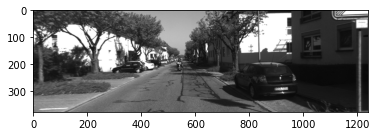

In [11]:
plt.imshow(next(datahandler.images_left))

In [51]:
def extract_features(image, detector = 'orb', mask = None):
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()

    #kp = det.detect(image, None)
    keypoints, descriptors = det.detectAndCompute(image, mask)
    return (keypoints, descriptors)

In [49]:
def extract_features_FAST(image):
    det = cv2.FastFeatureDetector_create()
    det.setNonmaxSuppression(True)
    det.setThreshold(20)
    keypoints = det.detect(image, None) 

    return (keypoints, 0)

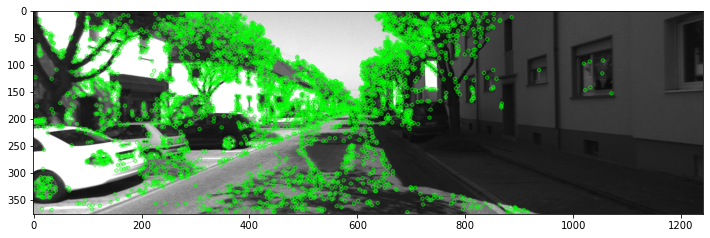

In [50]:
img = next(datahandler.images_left)
kp, des = extract_features_FAST(img)

plt.figure(figsize = (12, 4))
plt.imshow(cv2.drawKeypoints(img, kp, None, color = (0, 255, 0), flags = 0))

In [52]:
def match_features(desc1, desc2, matching = 'BF', detector = 'orb', sort = True, k = 2):

    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck = False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = False)

    elif matching == 'FLANN':
        index_params = dict(algorithm = 1, trees = 5)
        search_params = dict(checks = 50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        
    matches = matcher.knnMatch(desc1, desc2, k = k)
    if sort:
        matches = sorted(matches, key = lambda x: x[0].distance)

    return matches

In [ ]:
def visualize_matches(img1, kp1, img2, kp2, match):
    pass